importing Jupyter notebook from proj_env.ipynb
{'Serve Apple Salad to Person in Red': {('Go to Red Apple', 'Take Red Apple', 'Go to Green Apple', 'Take Green Apple', 'Go to Knife', 'Prepare Red Apple', 'Prepare Green Apple', 'Go to Mixing Bowl', 'Prepare Apple Salad', 'Place Apple Salad on Plate', 'Serve plate to Person in Red'), ('Go to Green Apple', 'Take Green Apple', 'Go to Red Apple', 'Take Red Apple', 'Go to Knife', 'Prepare Green Apple', 'Prepare Red Apple', 'Go to Mixing Bowl', 'Prepare Apple Salad', 'Place Apple Salad on Plate', 'Serve plate to Person in Red')}, 'Serve Cheese Platter to Person in White': {('Go to White Cheese', 'Take White Cheese', 'Go to Yellow Cheese', 'Take Yellow Cheese', 'Go to Knife', 'Prepare White Cheese', 'Prepare Yellow Cheese', 'Go to Plate', 'Place White Cheese on Plate', 'Place Yellow Cheese on Plate', 'Serve plate to Person in White'), ('Go to Yellow Cheese', 'Take Yellow Cheese', 'Go to White Cheese', 'Take White Cheese', 'Go to Knife', 'Prepare

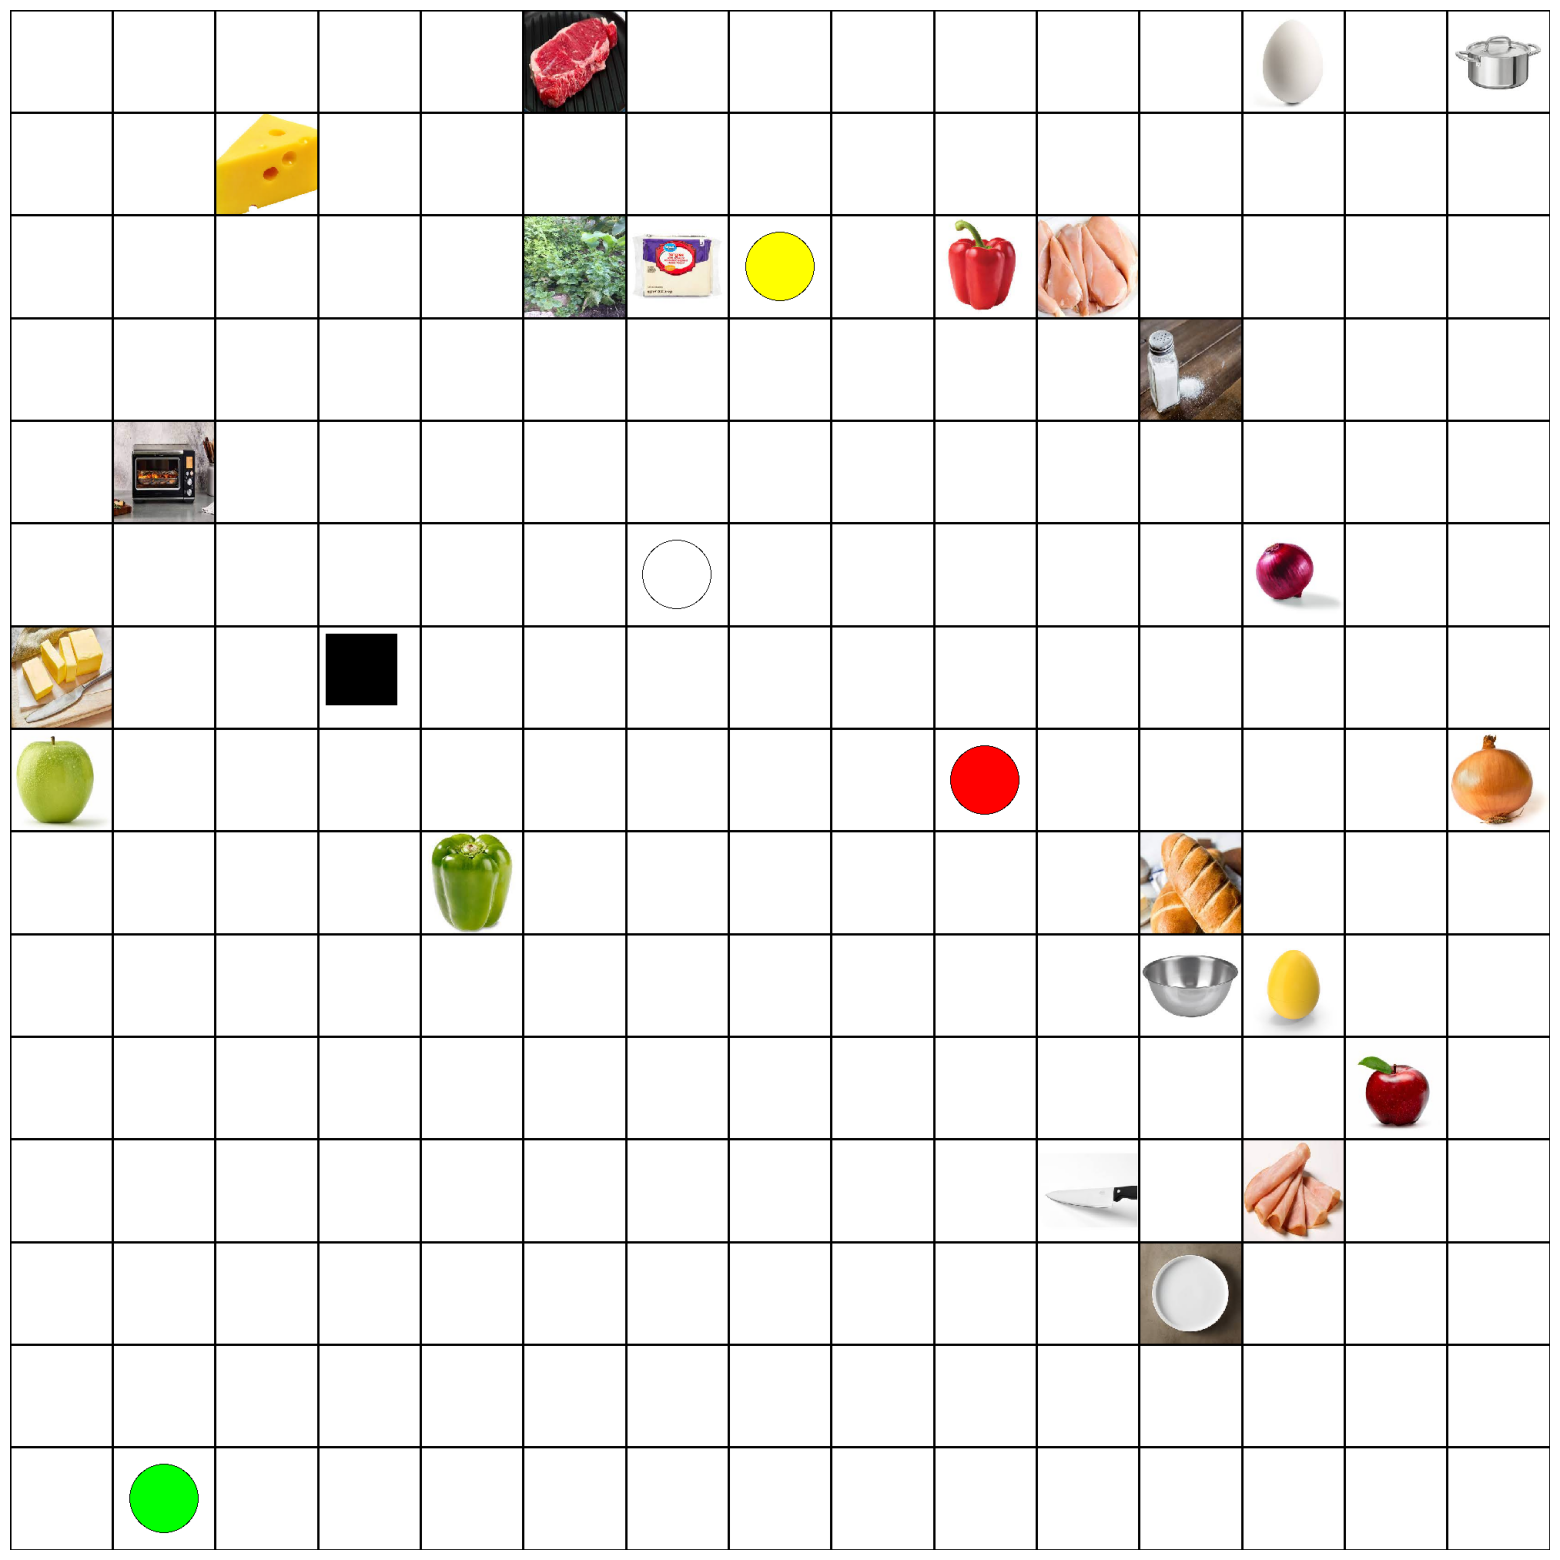

{'distance to Red Apple': 14.0, 'distance to Red Onions': 10.0, 'distance to Yellow Onions': 12.0, 'distance to Bread': 10.0, 'distance to Yellow Cheese': 6.0, 'distance to White Cheese': 7.0, 'distance to Red Bell Pepper': 10.0, 'distance to Green Bell Pepper': 3.0, 'distance to Green Apple': 4.0, 'distance to Yellow Egg': 12.0, 'distance to White Egg': 15.0, 'distance to Butter': 3.0, 'distance to Ham': 14.0, 'distance to Red Meat (Beef)': 8.0, 'distance to White Meat (Turkey)': 11.0, 'distance to Salt': 11.0, 'distance to Herbs': 6.0, 'distance to Pot': 17.0, 'distance to Oven': 4.0, 'distance to Knife': 12.0, 'distance to Mixing Bowl': 11.0, 'distance to Plate': 14.0, 'distance to Red Guest': 7.0, 'distance to White Guest': 4.0, 'distance to Green Guest': 10.0, 'distance to Yellow Guest': 8.0}
[]


[nltk_data] Downloading package punkt to /Users/lixiang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [1]:
import gym
import random
import import_ipynb
import proj_env
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import json
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
nltk.download('punkt')

down = np.array([1,0])
up = np.array([-1,0])
right = np.array([0,1])
left = np.array([0,-1])

action_to_direction = {1: right,2: left,3: down,4: up}


food_list = ["RedApple", "RedOnions", "YellowOnions", "Bread", "YellowCheese", "WhiteCheese",
         "RedBellPepper", "GreenBellPepper", "GreenApple", "YellowEgg", "WhiteEgg", "Butter",
         "Ham", "RedMeat", "WhiteMeat", "Salt", "Herbs"]

tools_list =[ "Pot", "Oven", "Knife", "MixingBowl"]

guest_list = ["Red","White","Green","Yellow"]





    

In [2]:
def create_env(seed):
    random.seed(seed)

    the_n_env = proj_env.GridWorldEnv(render_mode='rgb_array')
    the_n_env.reset(seed = seed)
    return the_n_env


In [3]:
def show_env(env):
    image_array = env._render_frame()

    plt.figure(figsize=(20, 20))
    # Display the image array
    plt.imshow(image_array)
    plt.axis('off')  # Hide the axis
    plt.show()


In [4]:
def movingList(distance):
    
    x = distance[0]
    y = distance[1]
    lst = []
    a_lst = []
    if x < 0:
        for i in range(x,0):
            lst.append(1)
            a_lst.append("Right")
    elif x > 0:
        for i in range(x):
            lst.append(2)
            a_lst.append("Left")
    if y < 0:
        for i in range(y,0):
            lst.append(3)
            a_lst.append("Down")
    elif y > 0:
        for i in range(y):
            lst.append(4)
            a_lst.append("Up")

    return lst, a_lst

In [5]:
"""
the_n_env=create_env(seed)
original_loc = the_n_env._Agent_location
plate_loc = the_n_env._Plate_location   
size = the_n_env.size
diff_loc = dict()
act_loc = dict()

for f in food_list:
    loc = getattr(the_n_env, "_"+f + "_location")
    distance = original_loc - loc
    x = distance[0]
    y = distance[1]
    lst,a_lst = movingList(distance)
    diff_loc[f] = lst
    act_loc[f] = a_lst

    distance_p = plate_loc - loc
    lst,a_lst = movingList(distance_p)
    o_lst , oa_lst = movingList(-distance_p)
    k = "Plate-"+f
    diff_loc[k] = lst
    act_loc[k] = a_lst

    k = f+"-Plate"
    diff_loc[k] = o_lst
    act_loc[k] = oa_lst

    for t in tools_list:
        t_loc = getattr(the_n_env, "_"+t + "_location")
        distance = original_loc - t_loc
        lst,a_lst = movingList(distance)
        diff_loc[t] = lst
        act_loc[t] = a_lst  
        
        distance = loc - t_loc
        lst,a_lst = movingList(distance)
        k = f+"-"+t
        diff_loc[k] = lst
        act_loc[k] = a_lst

        lst,a_lst = movingList(-distance)
        k = t+"-"+f
        diff_loc[k] = lst
        act_loc[k] = a_lst

        distance_p = t_loc - plate_loc
        lst,a_lst = movingList(distance_p)
        o_lst , oa_lst = movingList(-distance_p)
        k = t+"-Plate"
        diff_loc[k] = lst
        act_loc[k] = a_lst

        k = "Plate-"+t
        diff_loc[k] = o_lst
        act_loc[k] = oa_lst

        for g in guest_list:
            g_loc = getattr(the_n_env, "_"+g + "_location")
            distance = t_loc - g_loc
            lst,a_lst = movingList(distance)
            k = t+"-"+g
            diff_loc[k] = lst
            act_loc[k] = a_lst

            distance_p = plate_loc - g_loc
            lst,a_lst = movingList(distance_p)
            k = "Plate-"+g
            diff_loc[k] = lst
            act_loc[k] = a_lst

        for others_t in tools_list:
            if others_t!=t:
                other_loc = getattr(the_n_env, "_"+others_t + "_location")
                distance = t_loc - other_loc
                lst,a_lst = movingList(distance)
                k = t+"-"+others_t
                diff_loc[k] = lst
                act_loc[k] = a_lst

                lst,a_lst = movingList(-distance)
                k = others_t+"-"+t
                diff_loc[k] = lst
                act_loc[k] = a_lst
        
    for other in food_list:
        if other!=f:
            other_loc = getattr(the_n_env, "_"+other + "_location")
            distance = loc - other_loc
            lst,a_lst = movingList(distance)
            k = f+"-"+other
            diff_loc[k] = lst
            act_loc[k] = a_lst

            lst,a_lst = movingList(-distance)
            k = other+"-"+f
            diff_loc[k] = lst
            act_loc[k] = a_lst


diff_loc["Plate-Plate"] = []
def check_diff(diff_loc = diff_loc, k = None):
    for the_k in diff_loc.keys():
        if k in the_k:
            print(the_k)
            print(diff_loc[the_k])
check_diff(k = "Pan")"""

'\nthe_n_env=create_env(seed)\noriginal_loc = the_n_env._Agent_location\nplate_loc = the_n_env._Plate_location   \nsize = the_n_env.size\ndiff_loc = dict()\nact_loc = dict()\n\nfor f in food_list:\n    loc = getattr(the_n_env, "_"+f + "_location")\n    distance = original_loc - loc\n    x = distance[0]\n    y = distance[1]\n    lst,a_lst = movingList(distance)\n    diff_loc[f] = lst\n    act_loc[f] = a_lst\n\n    distance_p = plate_loc - loc\n    lst,a_lst = movingList(distance_p)\n    o_lst , oa_lst = movingList(-distance_p)\n    k = "Plate-"+f\n    diff_loc[k] = lst\n    act_loc[k] = a_lst\n\n    k = f+"-Plate"\n    diff_loc[k] = o_lst\n    act_loc[k] = oa_lst\n\n    for t in tools_list:\n        t_loc = getattr(the_n_env, "_"+t + "_location")\n        distance = original_loc - t_loc\n        lst,a_lst = movingList(distance)\n        diff_loc[t] = lst\n        act_loc[t] = a_lst  \n        \n        distance = loc - t_loc\n        lst,a_lst = movingList(distance)\n        k = f+"-"+t

In [6]:
def get_vocab(f_name):
    info = dict()
    with open(f_name,"r") as f:
        d = json.load(f)
        for i in d["dataset"]:
            e = i["key"]
            if e not in info.keys():
                v = i["value"]
                n_v = set()
                for value in v:
                    n_v.add(tuple(value))
                info[e] = n_v
            else:
                value = info[e]
                v = i["value"]
                n_v = set()
                for elements in v:
                    n_v.add(tuple(elements))
                n_v = value.union(n_v)
                info[e] = n_v

    return info

#info key is command, value is set with multiple solutions and each solution type is tuple



In [7]:
def commandAnalysis(step):
    command = step.split(" ")[0]
    t = step.split(" ")[-1]
    target = ""
    target += t[0].upper()
    target += t[1:].lower()
    if target == "Onion":
        target = step.split(" ")[-2]+"Onions"
    elif target == "Apple" or target == "Egg" or target == "Meat" or target == "Cheese":
        target = step.split(" ")[-2]+target
    elif target == "Pepper":
        target = step.split(" ")[-3]+"Bell"+target
    elif target == "Bowl":
        target = "Mixing"+target
    elif target == "(turkey)":
        target = "WhiteMeat"
    elif target == "(beef)":
        target = "RedMeat"
    else:
        target = target
    
    return command, target



In [10]:
def get_action(env,info):
    optimal_action = dict()
    for key in info.keys():
        value = info[key]
        big_v = []
        for v in value:
            small_v = []
            loc = env._Agent_location
            last_reach = loc
            for step in v:
                command, target = commandAnalysis(step)
                if command == "Go":
                    other_loc = getattr(env, "_"+target + "_location")
                    distance=last_reach-other_loc
                    lst,a_lst = movingList(distance)
                    small_v += lst
                    last_reach = other_loc
                elif command == "Take":
                    small_v.append(5)
                
                elif command == "Prepare":
                    small_v.append(6)

                elif command == "Place":
                    other_loc = getattr(env, "_Plate_location")
                    distance=last_reach-other_loc
                    lst,a_lst = movingList(distance)
                    small_v += lst
                    last_reach = other_loc
                    small_v.append(6)

                elif command == "Serve":
                    other_loc = getattr(env, "_"+target + "_location")
                    distance=last_reach-other_loc
                    lst,a_lst = movingList(distance)
                    small_v += lst
                    last_reach = other_loc
                    small_v.append(7)
            big_v.append(small_v)
        optimal_action[key] = min(big_v, key=len)
    return optimal_action

def get_correct_dict(env,optimal_action):
    for i in optimal_action:
        env.step(i-1)
    return env.get_food_on()



In [11]:
info = get_vocab("699_recipe_data.json")
env=create_env(0)
optimal_action = get_action(env,info)
optimal_act=optimal_action['Serve Apple Salad to Person in Red']
print(get_correct_dict(env,optimal_act))

{'RedApple': ['Knife', 'MixingBowl', 'Plate'], 'RedOnions': [], 'YellowOnions': [], 'Bread': [], 'YellowCheese': [], 'WhiteCheese': [], 'RedBellPepper': [], 'GreenBellPepper': [], 'GreenApple': ['Knife', 'MixingBowl', 'Plate'], 'YellowEgg': [], 'WhiteEgg': [], 'Butter': [], 'Ham': [], 'RedMeat': [], 'WhiteMeat': [], 'Salt': [], 'Herbs': []}


In [375]:
def make_words_tokenize(optimal_action):
    tokenized = [word_tokenize(text) for text in optimal_action.keys()]

    all_tokens = [token for text in tokenized  for token in text]
    vocab = Counter(all_tokens)

    word_to_index = {word: i + 1 for i, (word, _) in enumerate(vocab.items())}
    print(word_to_index)

    tokenized_texts_indices = [[word_to_index[token] for token in text] for text in tokenized]

    # Define a maximum sequence length
    max_length = max(len(text) for text in tokenized_texts_indices)

    # Pad sequences with zeros
    padded_sequences = [text + [0] * (20 - len(text)) for text in tokenized_texts_indices]

    return padded_sequences, word_to_index, max_length




In [377]:
def make_action_tensor(optimal_action, word_to_index, max_length):
    opt_short_action = []
    for k in optimal_action.keys():
        v = optimal_action[k]

        if len(v) > 1:
            first = len(v[0])
            second = len(v[1])
            if first < second:
                opt_short_action.append(v[0])
            else:
                opt_short_action.append(v[1])
        else:
            opt_short_action.append(v[0])

    print(opt_short_action)


    max_l =  max(len(act) for act in opt_short_action)


    padded_act = [act + [0] * (max_l - len(act)) for act in opt_short_action]
    return padded_act,max_l


In [378]:
padded_sequences, word_to_index, max_length = make_words_tokenize(optimal_action)
padded_act,max_l = make_action_tensor(optimal_action, word_to_index, max_length)

{'Serve': 1, 'Apple': 2, 'Salad': 3, 'to': 4, 'Person': 5, 'in': 6, 'Red': 7, 'Cheese': 8, 'Platter': 9, 'for': 10, 'Customer': 11, 'White': 12, 'and': 13, 'Herb': 14, 'Spread': 15, 'Green': 16, 'Give': 17, 'the': 18, 'Yellow': 19, 'a': 20, 'Bell': 21, 'Pepper': 22, 'Grilled': 23, 'Sandwich': 24, 'Turkey': 25, 'Snack': 26, 'customer': 27, 'Butter': 28, 'Stuffed': 29, 'Peppers': 30, 'guest': 31, 'Beef': 32, 'Stir-Fry': 33, 'an': 34, 'A': 35, 'Wrap': 36, 'Steak': 37, 'Onion': 38, 'Tart': 39, 'Ham': 40, 'Omelette': 41}
[[3, 3, 3, 3, 3, 3, 5, 2, 2, 2, 2, 2, 2, 2, 2, 3, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 6, 2, 2, 3, 3, 6, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7], [2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 1, 4, 4, 4, 4, 6, 1, 1, 1, 1, 4, 4, 4, 6, 6, 1, 1, 1, 1, 1, 

In [318]:
obs_lst = []
for f in food_list:
    obs_lst.append(getattr(the_n_env, "_"+f + "_location"))
for t in tools_list:
    obs_lst.append(getattr(the_n_env, "_"+t + "_location"))
for g in guest_list:
    obs_lst.append(getattr(the_n_env, "_"+g + "_location"))
obs_lst.append(the_n_env._Agent_location)
obs_lst.append(the_n_env._Plate_location)
obs_lst = torch.tensor(np.array(obs_lst)).float()

obs_mean = torch.mean(obs_lst, dim=0)  # Mean (2 values)
obs_std = torch.std(obs_lst, dim=0)  # Standard deviation (2 values)
obs_summary = torch.cat((obs_mean, obs_std))  # Summary vector (4 values)
print(obs_summary.shape)
print(obs_summary)

28
28


In [379]:
dataset = TensorDataset(torch.tensor(padded_sequences), torch.tensor(padded_act))

In [380]:
batch_size = 10  # You can adjust this according to your needs

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [381]:
class BehaviorCloningModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes=8):
        super(BehaviorCloningModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_classes, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_layers)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM

        out, _ = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)


        # Decode the hidden state of the last time step
        out = self.fc(out)  # out: tensor of shape (batch_size, seq_length, num_classes)

        return out



In [382]:
vocab_size = len(word_to_index) + 1  # Assuming word_to_index is your vocabulary index
embedding_dim = 128  # Example value
hidden_dim = 256  # Example value
num_actions = 8  # Assuming 7 different actions + 1 for padding

In [383]:
def training(model,dataloader,obs,lr,epoch):
    criterion = nn.HuberLoss()
    optimizer = optim.Adam(model.parameters(), lr)

    num_epochs = epoch  # Example value

    # model.train()
    pbar = tqdm(range(num_epochs), desc="Training", unit="epoch")
    for epoch in pbar:
        for input_batch, target_batch in dataloader:  # Assuming dataloader is your data loader
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            n = input_batch.shape[0]
            obs_summary_repeated = obs_summary.repeat(n, 1)
            input_batch = torch.cat((input_batch.float(), obs_summary_repeated), dim=1)
            outputs = model(input_batch.float())
            loss = criterion(outputs.float(), target_batch.float())

            # Backward pass and optimize
            loss.backward()
            optimizer.step()
        pbar.set_postfix(Loss=loss,The_epoch=epoch+1)
    return model

In [384]:
class BehaviorCloningModel2(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_actions):
        super(BehaviorCloningModel2, self).__init__()
        
        self.fc1 = nn.Linear(vocab_size, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_actions)



    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)


        return x

In [ ]:
def make_words_tokenize_test(optimal_action, model_input_size):
    tokenized = [word_tokenize(text) for text in optimal_action.keys()]

    all_tokens = [token for text in tokenized  for token in text]
    vocab = Counter(all_tokens)

    word_to_index = {word: i + 1 for i, (word, _) in enumerate(vocab.items())}
    print(word_to_index)

    tokenized_texts_indices = [[word_to_index[token] for token in text] for text in tokenized]

    # Define a maximum sequence length
    max_length = max(len(text) for text in tokenized_texts_indices)

    if max_length <= model_input_size:
        max_length = model_input_size


    # Pad sequences with zeros
    padded_sequences = [text + [0] * (max_length - len(text)) for text in tokenized_texts_indices]

    return padded_sequences, word_to_index, max_length

In [385]:
def testing(f_name,theModel,word_to_index,info=info,diff_loc=diff_loc):
    info = get_vocab(f_name)
    optimal_action = get_action(info,diff_loc)
    print(info)
    padded_sequences, word_to_index, max_length_test = make_words_tokenize_test(optimal_action, 20)
    padded_act,_ = make_action_tensor(optimal_action, word_to_index, max_length_test)
    dataset = TensorDataset(torch.tensor(padded_sequences), torch.tensor(padded_act))
    batch_size = 1  # You can adjust this according to your needs

    dataloader = DataLoader(dataset, batch_size=batch_size)
    for input_batch, target_batch in dataloader:
        n = input_batch.shape[0]
        obs_summary_repeated = obs_summary.repeat(n, 1)
        input_batch = torch.cat((input_batch.float(), obs_summary_repeated), dim=1)
        result = theModel(input_batch.float())
        diff_total = 0
        action_sum = 0
        
        for i in range(len(target_batch[0])):
            if target_batch[0][i]!=0:
                diff = abs(result[0][i]-target_batch[0][i])
                diff_total += diff
                action_sum += target_batch[0][i]
            else:
                break
        print(diff_total/action_sum)
        # print(result)
        # print(target_batch)

    


Training: 100%|██████████| 5000/5000 [00:18<00:00, 272.92epoch/s, Loss=tensor(0.0040, grad_fn=<HuberLossBackward0>), The_epoch=5000]    


In [387]:
model1 = BehaviorCloningModel2(20+obs_summary.shape[0], hidden_dim, max_l)
model1 = training(model1,dataloader,obs_summary,0.01,10000)
testing("699_recipe_test_1.json",model1,word_to_index,info=info,diff_loc=diff_loc)
testing("699_recipe_test_2.json",model1,word_to_index,info=info,diff_loc=diff_loc)

In [405]:
model2 = BehaviorCloningModel2(20+obs_summary.shape[0], hidden_dim, max_l)
model2 = training(model2,dataloader,obs_summary,0.045,10000)
testing("699_recipe_test_1.json",model2,word_to_index,info=info,diff_loc=diff_loc)
testing("699_recipe_test_2.json",model2,word_to_index,info=info,diff_loc=diff_loc)

{'Serve Apple Salad to Person in Green': {('Go to Green Apple', 'Take Green Apple', 'Go to Red Apple', 'Take Red Apple', 'Go to Knife', 'Prepare', 'Go to Mixing Bowl', 'Prepare', 'Place Apple Salad on Plate', 'Serve plate to Person in Green'), ('Go to Red Apple', 'Take Red Apple', 'Go to Green Apple', 'Take Green Apple', 'Go to Knife', 'Prepare', 'Go to Mixing Bowl', 'Prepare', 'Place Apple Salad on Plate', 'Serve plate to Person in Green')}, 'Cheese Platter for Customer in Yellow': {('Go to White Cheese', 'Take White Cheese', 'Go to Yellow Cheese', 'Take Yellow Cheese', 'Go to Knife', 'Prepare', 'Go to Plate', 'Place White Cheese on Plate', 'Place Yellow Cheese on Plate', 'Serve plate to Person in Yellow'), ('Go to Yellow Cheese', 'Take Yellow Cheese', 'Go to White Cheese', 'Take White Cheese', 'Go to Knife', 'Prepare', 'Go to Plate', 'Place White Cheese on Plate', 'Place Yellow Cheese on Plate', 'Serve plate to Person in Yellow')}, 'Serve Cheese and Herb Spread to guest in White': {(

In [407]:
model3 = BehaviorCloningModel2(20+obs_summary.shape[0], hidden_dim, max_l)
model3 = training(model3,dataloader,obs_summary,0.008,10)
testing("699_recipe_test_1.json",model3,word_to_index,info=info,diff_loc=diff_loc)
testing("699_recipe_test_2.json",model3,word_to_index,info=info,diff_loc=diff_loc)

{'Bring a Herb Butter to the handsome guy in Yellow': {('Go to Herbs', 'Take Herbs', 'Go to Butter', 'Take Butter', 'Go to Knife', 'Prepare', 'Go to Mixing Bowl', 'Prepare', 'Place Herb Butter on Plate', 'Serve plate to Person in Yellow'), ('Go to Butter', 'Take Butter', 'Go to Herbs', 'Take Herbs', 'Go to Knife', 'Prepare', 'Go to Mixing Bowl', 'Prepare', 'Place Herb Butter on Plate', 'Serve plate to Person in Yellow')}, 'The Red diner orders a Stuffed Bell Peppers': {('Go to Red Bell Pepper', 'Take Red Bell Pepper', 'Go to Green Bell Pepper', 'Take Green Bell Pepper', 'Go to White Cheese', 'Take White Cheese', 'Go to Knife', 'Prepare', 'Go to Mixing Bowl', 'Prepare', 'Go to Oven', 'Prepare', 'Place Stuffed Bell Peppers on Plate', 'Serve plate to Person in Red'), ('Go to Green Bell Pepper', 'Take Green Bell Pepper', 'Go to Red Bell Pepper', 'Take Red Bell Pepper', 'Go to White Cheese', 'Take White Cheese', 'Go to Knife', 'Prepare', 'Go to Mixing Bowl', 'Prepare', 'Go to Oven', 'Prepar

In [ ]:
obs_embed = torch.tensor(obs_lst).float()
obs_flattened = obs_embed.flatten()
print(obs_flattened.shape)

In [ ]:
model3 = BehaviorCloningModel2(20+obs_summary.shape[0], hidden_dim, max_l)
model3 = training(model1,dataloader,obs_summary,0.01,10000)
testing("699_recipe_test_1.json",model2,word_to_index,info=info,diff_loc=diff_loc)
testing("699_recipe_test_2.json",model2,word_to_index,info=info,diff_loc=diff_loc)